## import

In [1]:
# Input data files are available in the "../data/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import gc
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
from tqdm import tqdm
from time import sleep
import networkx as nx
print(os.listdir("./data"))

import matplotlib.pyplot as plt
%matplotlib inline

['sample_submission.csv', 'sample_submission.csv.zip', 'sample_submission_2.csv', 'sample_submission_2.csv.zip', 'submission-005-all2000000.csv', 'test.csv', 'test.csv.zip', 'train.csv', 'train.csv.zip', 'train_id.csv']


In [24]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import lightgbm as lgb

In [2]:
def save_dataframe(path, dataframe):
    np.save(path + ".data", dataframe.values)
    np.save(path + ".header", dataframe.columns)
    
def load_dataframe(path):
    data = np.load(path + ".data.npy")
    header = np.load(path + ".header.npy")
    return pd.DataFrame(data=data, columns=header)

def save_dataframe32(path, dataframe, keep=[]):
    col64 = [col_ for col_ in dataframe.columns if col_ in keep]
    col32 = [col_ for col_ in dataframe.columns if col_ not in keep]
    dataframe64 = dataframe[col64]
    dataframe32 = dataframe[col32]
    np.save(path + ".data64", dataframe64.values)
    np.save(path + ".header64", col64)
    np.save(path + ".data32", dataframe32.values.astype(np.float32))
    np.save(path + ".header32", col32)

def load_dataframe32(path):
    path_data32 = path + ".data32.npy"
    path_header32 = path + ".header32.npy"
    path_data64 = path + ".data64.npy"
    path_header64 = path + ".header64.npy"
    result = pd.DataFrame()
    if os.path.exists(path_data32):
        data32 = np.load(path_data32)
        header32 = np.load(path_header32)
        df32 = pd.DataFrame(data=data32, columns=header32)
        result = pd.concat([result, df32], axis=1)
    if os.path.exists(path_data64):
        data64 = np.load(path_data64)
        header64 = np.load(path_header64)
        df64 = pd.DataFrame(data=data64, columns=header64)
        result = pd.concat([result, df64], axis=1)
    return result

In [3]:
def get_data():
    train = load_dataframe32("./bindata/train")
    test = load_dataframe32("./bindata/test")
    print('Train shape ', train.shape, ' Test shape ', test.shape)
    return train, test

## lkg functions

### construct_nobranch_graph

In [4]:
def construct_graph(data, key_len=5):
    tar_columns = [
        'f190486d6', '58e2e02e6', 'eeb9cd3aa', '9fd594eec', '6eef030c1', 
        '15ace8c9f', 'fb0f5dbfe', '58e056e12', '20aa07010', '024c577b9', 
        'd6bb78916', 'b43a7cfd5', '58232a6fb', '1702b5bf0', '324921c7b', 
        '62e59a501', '2ec5b290f', '241f0f867', 'fb49e4212', '66ace2992', 
        'f74e8f13d', '5c6487af1', '963a49cdc', '26fc93eb7', '1931ccfdd', 
        '703885424', '70feb1494', '491b9ee45', '23310aa6f', 'e176a204a', 
        '6619d81fc', '1db387535', 'fc99f9426', '91f701ba2', '0572565c2',
        '190db8488', 'adb64ff71', 'c47340d97', 'c5a231d81', '0ff32eb98',
    ]

    id_columns = ["ID"] + tar_columns
    fixed_piece = tar_columns[:key_len]

    data = data[id_columns].copy()
    data["fixed_key"] = data[fixed_piece].apply(lambda x: "_".join(map(str, x)), axis=1)
    # remove fixed key zero
    data = data[data.fixed_key != "0.0_0.0_0.0_0.0_0.0"].copy()
    fixed_key_vc = data.fixed_key.value_counts()
    fixed_key_unique = fixed_key_vc[fixed_key_vc == 1]
    data = data[data.fixed_key.isin(fixed_key_unique.index)].copy()

    # print(fixed_key_unique.shape)
    # print(data.shape)

    data["left_linked"] = False
    data["right_linked"] = False

    match_stack = []
    max_len = len(tar_columns)

    for lag in tqdm(range(1, max_len - key_len + 1)):
        lag_piece = tar_columns[lag:lag + key_len]
        data.loc[~data.left_linked, "lag_key"] = data.loc[~data.left_linked, lag_piece].apply(lambda x: "_".join(map(str, x)), axis=1)

        lag_match = pd.merge(
            data[~data.right_linked].drop(tar_columns + ["lag_key"], axis=1),
            data[~data.left_linked].drop(tar_columns + ["fixed_key"], axis=1),
            left_on="fixed_key",
            right_on="lag_key",
            how="inner"
        )[["ID_x", "ID_y"]].rename(columns={"ID_x": "left_id", "ID_y": "right_id"}).copy()

        lag_match["lag"] = lag
        match_stack.append(lag_match)

        left_match = data.ID.isin(lag_match.left_id)
        right_match = data.ID.isin(lag_match.right_id)

        data.loc[right_match, "left_linked"] = True
        data.loc[left_match, "right_linked"] = True

    return pd.concat(match_stack)


def get_dup_ids(graph):
    left_id_vc = graph.left_id.value_counts()
    right_id_vc = graph.right_id.value_counts()
    
    left_id_dup = set(left_id_vc[left_id_vc > 1].index)
    right_id_dup = set(right_id_vc[right_id_vc > 1].index)

    left_ids_match = set(graph[graph.right_id.isin(right_id_dup)].left_id)
    right_ids_match = set(graph[graph.left_id.isin(left_id_dup)].right_id)
    
    all_dup = left_id_dup | right_id_dup | left_ids_match | right_ids_match
    return graph[~graph.left_id.isin(left_id_dup) & ~graph.right_id.isin(right_id_dup)].copy(), all_dup

def construct_nobranch_graph(data):
    key_len = 10
    print("key-len:", key_len)
    graph = construct_graph(data, key_len)
    graph, all_dup = get_dup_ids(graph)
    
    for key_len_ in (20, 25, 35):
        print("dup-ids: {}, key-len: {}".format(len(all_dup), key_len_))
        if len(all_dup) > 0:
            graph_ = construct_graph(data[data.ID.isin(all_dup)], key_len_)
            graph_, all_dup_ = get_dup_ids(graph_)

            graph = graph.append(graph_).drop_duplicates()
            graph, all_dup = get_dup_ids(graph)
            all_dup = all_dup | all_dup_

    print("dup-ids:", len(all_dup))
    return graph

### get_path

In [5]:
def get_path(dgraph, head):
    cur = head
    offset = 0
    path = [(cur, offset)]

    while 1:
        suc_ = dgraph.successors(cur)
        if len(suc_) == 0:
            break

        offset += dgraph[cur][suc_[0]]["weight"]
        cur = suc_[0]
        if cur in path:
            print(cur)
            break

        path.append((cur, offset))
    return path

### get_real_path

In [6]:
def get_real_path(head, data, path_stack):
    tar_columns = [
        'f190486d6', '58e2e02e6', 'eeb9cd3aa', '9fd594eec', '6eef030c1', 
        '15ace8c9f', 'fb0f5dbfe', '58e056e12', '20aa07010', '024c577b9', 
        'd6bb78916', 'b43a7cfd5', '58232a6fb', '1702b5bf0', '324921c7b', 
        '62e59a501', '2ec5b290f', '241f0f867', 'fb49e4212', '66ace2992', 
        'f74e8f13d', '5c6487af1', '963a49cdc', '26fc93eb7', '1931ccfdd', 
        '703885424', '70feb1494', '491b9ee45', '23310aa6f', 'e176a204a', 
        '6619d81fc', '1db387535', 'fc99f9426', '91f701ba2', '0572565c2',
        '190db8488', 'adb64ff71', 'c47340d97', 'c5a231d81', '0ff32eb98',
    ]
    
    path = path_stack[head]
    path_len = len(path)

    value_arr_stack = []
    path_arr_stack = []
    head_stack = []

    path_arr = []
    value_arr = np.array([])

    init_pos = 0
    for i, (post_node_, post_offset_) in enumerate(path):
        if i == 0:
            pre_node_, pre_offset_ = post_node_, post_offset_
            pre_values = data[data["ID"] == pre_node_][tar_columns].values[0]
            value_arr = np.append(pre_values, value_arr)
            path_arr.append((pre_node_, pre_offset_ - init_pos))
            head_stack.append(pre_node_)
            continue

        offset = post_offset_ - pre_offset_
        post_values = data[data["ID"] == post_node_][tar_columns].values[0]
        match = (pre_values[:-offset] != post_values[offset:]).sum() == 0
        rest2 = i < (path_len -2)

        if match:
            value_arr = np.append(post_values[:offset], value_arr)
            path_arr.append((post_node_, post_offset_ - init_pos))
        elif rest2:
            value_arr_stack.append(value_arr)
            value_arr = post_values.copy()
            path_arr_stack.append(path_arr)
            init_pos = post_offset_
            path_arr = [(post_node_, post_offset_ - init_pos)]
            head_stack.append(post_node_)
        else:
            break

        pre_node_, pre_offset_ = post_node_, post_offset_
        pre_values = post_values

    value_arr_stack.append(value_arr)
    path_arr_stack.append(path_arr)
    return head_stack, path_arr_stack, value_arr_stack

### get_target_lkg

In [7]:
def get_target_lkg(realstack):
    allheads = sum([x[0] for x in realstack], [])
    allpaths = sum([x[1] for x in realstack], [])
    allvalues = sum([x[2] for x in realstack], [])

    head_stack = []
    rowid_stack = []
    offset_stack = []
    tail_stack = []
    target_stack = []

    for i in tqdm(range(len(allheads))):
        head_ = allheads[i]
        path_ = allpaths[i]
        value_ = allvalues[i]
        path_len = len(path_)
        arr_len = len(value_)
        if path_len == 1:
            continue
        
        head_stack += [head_] * path_len
        rowid_stack += [x[0] for x in path_]
        offset_arr =[x[1] for x in path_]
        offset_stack += offset_arr
        tail_stack += list(value_[[-40 - offset_ for offset_ in offset_arr]])
        target_stack += [value_[-42 - offset_] if (42 + offset_) <= arr_len else -1 for offset_ in offset_arr]

    return pd.DataFrame({
        "head": head_stack,
        "rowid": rowid_stack,
        "offset": offset_stack,
        "tail": tail_stack,
        "target_lkg": target_stack
    })

## construct_graph: train_test

In [8]:
train, test = get_data()

test["target"] = -1
columns = [
    "ID", "target",
    'f190486d6', '58e2e02e6', 'eeb9cd3aa', '9fd594eec', '6eef030c1', 
    '15ace8c9f', 'fb0f5dbfe', '58e056e12', '20aa07010', '024c577b9', 
    'd6bb78916', 'b43a7cfd5', '58232a6fb', '1702b5bf0', '324921c7b', 
    '62e59a501', '2ec5b290f', '241f0f867', 'fb49e4212', '66ace2992', 
    'f74e8f13d', '5c6487af1', '963a49cdc', '26fc93eb7', '1931ccfdd', 
    '703885424', '70feb1494', '491b9ee45', '23310aa6f', 'e176a204a', 
    '6619d81fc', '1db387535', 'fc99f9426', '91f701ba2', '0572565c2',
    '190db8488', 'adb64ff71', 'c47340d97', 'c5a231d81', '0ff32eb98',
]

tar_columns = [
    'f190486d6', '58e2e02e6', 'eeb9cd3aa', '9fd594eec', '6eef030c1', 
    '15ace8c9f', 'fb0f5dbfe', '58e056e12', '20aa07010', '024c577b9', 
    'd6bb78916', 'b43a7cfd5', '58232a6fb', '1702b5bf0', '324921c7b', 
    '62e59a501', '2ec5b290f', '241f0f867', 'fb49e4212', '66ace2992', 
    'f74e8f13d', '5c6487af1', '963a49cdc', '26fc93eb7', '1931ccfdd', 
    '703885424', '70feb1494', '491b9ee45', '23310aa6f', 'e176a204a', 
    '6619d81fc', '1db387535', 'fc99f9426', '91f701ba2', '0572565c2',
    '190db8488', 'adb64ff71', 'c47340d97', 'c5a231d81', '0ff32eb98',
]

train_test = pd.concat([train[columns], test[columns]])
print("train_test.shape:", train_test.shape)

Train shape  (4459, 4993)  Test shape  (49343, 4992)
train_test.shape: (53802, 42)


In [9]:
%time
print("Construct Graph")
train_test_graph = construct_nobranch_graph(train_test)

train_test_nxgraph = nx.DiGraph()
train_test_nxgraph.add_weighted_edges_from(train_test_graph[["left_id", "right_id", "lag"]].values)

train_test_headset = {key for key, val in train_test_nxgraph.in_degree().items() if val == 0}
train_test_tailset = {key for key, val in train_test_nxgraph.out_degree().items() if val == 0}

print("Get Path From Nxgraph")
train_test_pathstack = {head_: get_path(train_test_nxgraph, head_) for head_ in tqdm(train_test_headset)}

print("Get Path Values")
train_test_realstack = [get_real_path(head_, train_test, train_test_pathstack) for head_ in tqdm(train_test_pathstack)]

print("Match Target Lkg")
train_test_targetlkg = get_target_lkg(train_test_realstack)

Construct Graph
key-len: 10


100%|██████████████████████████████████████████| 30/30 [00:10<00:00,  2.88it/s]


dup-ids: 295, key-len: 20


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 44.15it/s]


dup-ids: 44, key-len: 25


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 67.56it/s]


dup-ids: 25, key-len: 35


100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 73.53it/s]


dup-ids: 19
Get Path From Nxgraph


100%|███████████████████████████████████| 1194/1194 [00:00<00:00, 44219.96it/s]


Get Path Values


100%|██████████████████████████████████████| 1194/1194 [00:58<00:00, 20.28it/s]


Match Target Lkg


100%|██████████████████████████████████| 1423/1423 [00:00<00:00, 129356.19it/s]


In [10]:
train_test_targetlkg.head()

,head,rowid,offset,tail,target_lkg
0,ed367b11e,ed367b11e,0,0.0,10000000.0
1,ed367b11e,fb4a59db0,1,0.0,10000000.0
2,ed367b11e,51db2de6d,5,0.0,10000000.0
3,ed367b11e,c6f73c4d3,8,0.0,-1.0
4,a07b50af6,a07b50af6,0,0.0,2000000.0


## split train test

In [12]:
%time
train_test = pd.concat([train, test])

all_features = [f for f in train_test if f not in {"ID", "target"}]
tar_features = tar_columns
train_test.replace(0, np.nan, inplace=True)
print('the_logmean')
train_test['the_logmean'] = np.log1p(train_test[all_features].replace(0, np.nan).mean(axis=1))
print('the_meanlog')
train_test['the_meanlog'] = np.log1p(train_test[all_features]).replace(0, np.nan).mean(axis=1)
print('the_logmedian')
train_test['the_logmedian'] = np.log1p(train_test[all_features].replace(0, np.nan).median(axis=1))
print('the_nbnans')
train_test['the_nbnans'] = train_test[all_features].isnull().sum(axis=1)
print('the_sum')
train_test['the_sum'] = np.log1p(train_test[all_features].sum(axis=1))
print('the_std')
train_test['the_std'] = train_test[all_features].std(axis=1)
print('the_kur')
train_test['the_kur'] = train_test[all_features].kurtosis(axis=1)
print('tar_logmean')
train_test['tar_logmean'] = np.log1p(train_test[tar_features].replace(0, np.nan).mean(axis=1))
print('tar_meanlog')
train_test['tar_meanlog'] = np.log1p(train_test[tar_features]).replace(0, np.nan).mean(axis=1)
print('tar_logmedian')
train_test['tar_logmedian'] = np.log1p(train_test[tar_features].replace(0, np.nan).median(axis=1))
print('tar_nbnans')
train_test['tar_nbnans'] = train_test[tar_features].isnull().sum(axis=1)
print('tar_sum')
train_test['tar_sum'] = np.log1p(train_test[tar_features].sum(axis=1))
print('tar_std')
train_test['tar_std'] = train_test[tar_features].std(axis=1)
print('tar_kur')
train_test['tar_kur'] = train_test[tar_features].kurtosis(axis=1)

the_logmean
the_meanlog
the_logmedian
the_nbnans
the_sum
the_std
the_kur
tar_logmean
tar_meanlog
tar_logmedian
tar_nbnans
tar_sum
tar_std
tar_kur


In [13]:
train_new_ids = set(train.ID.unique()) | set(train_test_targetlkg[train_test_targetlkg.target_lkg.notnull() & (train_test_targetlkg.target_lkg > 0)].rowid.unique())
train_new = train_test[train_test.ID.isin(train_new_ids)].copy()
test_new = train_test[~train_test.ID.isin(train_new_ids)].copy()
print("Train_new.shape:{}, Test_new.shape:{}".format(train_new.shape, test_new.shape))

Train_new.shape:(10028, 5007), Test_new.shape:(43774, 5007)


In [21]:
train_new["target_lkg"] = train_new.ID.map(train_test_targetlkg.set_index("rowid").target_lkg)
train_new.loc[train_new.target == -1, "target"] = train_new.loc[train_new.target == -1, "target_lkg"]
train_new["target_log"] = np.log1p(train_new.target)

## cv: lightgbm

In [16]:
good_features = [
    '6eef030c1', 'ba42e41fa', '703885424', 'eeb9cd3aa', '3f4a39818',
    '371da7669', 'b98f3e0d7', 'fc99f9426', '2288333b4', '324921c7b',
    '66ace2992', '84d9d1228', '491b9ee45', 'de4e75360', '9fd594eec',
    'f190486d6', '62e59a501', '20aa07010', 'c47340d97', '1931ccfdd',
    'c2dae3a5a', 'e176a204a'
]

stats_features = [
    'the_logmean',
    'the_meanlog',
    'the_logmedian',
    'the_nbnans',
    'the_sum',
    'the_std',
    'the_kur',
    'tar_logmean',
    'tar_meanlog',
    'tar_logmedian',
    'tar_nbnans',
    'tar_sum',
    'tar_std',
    'tar_kur',
]

In [29]:
lgb_features = good_features + stats_features

lgb_params = {
    'objective': 'regression',
    'num_leaves': 58,
    'subsample': 0.6143,
    'colsample_bytree': 0.6453,
    'min_split_gain': np.power(10, -2.5988),
    'reg_alpha': np.power(10, -2.2887),
    'reg_lambda': np.power(10, 1.7570),
    'min_child_weight': np.power(10, -0.1477),
    'verbose': -1,
    'seed': 3,
    'boosting_type': 'gbdt',
    'max_depth': -1,
    'learning_rate': 0.05,
    'metric': 'l2',
}

dtrain = lgb.Dataset(data=train_new[lgb_features], label=train_new.target_log, free_raw_data=False)
dtrain.construct()

oof_preds = np.zeros(train_new.shape[0])
folds = KFold(n_splits=5, shuffle=True, random_state=1)

for trn_idx, val_idx in tqdm(folds.split(train_new)):
    clf = lgb.train(
        params=lgb_params,
        train_set=dtrain.subset(trn_idx),
        valid_sets=dtrain.subset(val_idx),
        num_boost_round=10000, 
        early_stopping_rounds=100,
        verbose_eval=0
    )

    oof_preds[val_idx] = clf.predict(dtrain.data.iloc[val_idx])
    test_new['target'] += clf.predict(test_new[lgb_features]) / folds.n_splits
    print(mean_squared_error(train_new.iloc[val_idx].target_log, oof_preds[val_idx]) ** .5)
    
print('OOF SCORE : %9.6f' % (mean_squared_error(train_new.target_log, oof_preds) ** .5))

0it [00:00, ?it/s]

1.3053181369921398


1it [00:01,  1.60s/it]

1.2902169078948211


2it [00:02,  1.48s/it]

1.3431781737793262


3it [00:04,  1.59s/it]

1.3458261179327817


4it [00:06,  1.65s/it]

1.325434727316247


5it [00:08,  1.63s/it]


OOF SCORE :  1.322167


In [30]:
test_new["target"] = np.expm1(test_new.target)

In [52]:
def modify(target_int_str):
    for i in range(1, len(target_int_str)):
        if target_int_str[i] == "0":
            return target_int_str[:i] + "0" * (len(target_int_str) - i)
        if i + 1 < len(target_int_str) and target_int_str[i] == "9" and target_int_str[i+1] == "9":
            return str(int(target_int_str[:i]) + 1) + "0" * (len(target_int_str) - i)
        if 4 < i + 1 < len(target_int_str) and target_int_str[i] == "9" and int(target_int_str[i+1]) >= 7:
            return str(int(target_int_str[:i]) + 1) + "0" * (len(target_int_str) - i)
        if 4 < i + 1 < len(target_int_str) and target_int_str[i] == "1" and target_int_str[i+1] == "0":
            return str(int(target_int_str[:i]) - 1) + "0" * (len(target_int_str) - i)
        if 5 < i + 1 < len(target_int_str) and int(target_int_str[i+1]) > 7:
            return str(int(target_int_str[:i]) + 1) + "0" * (len(target_int_str) - i)
        if 5 < i + 1 < len(target_int_str) and int(target_int_str[i+1]) < 3:
            return str(int(target_int_str[:i]) + 1) + "0" * (len(target_int_str) - i)
    return target_int_str

submission = pd.read_csv("./result/submission-005-lkg.csv")
test_new["target_mod"] = test_new.target.astype("int").astype("str").apply(modify)
submission["target_pred"] = submission.ID.map(test_new[["ID", "target_mod"]].set_index("ID").target_mod.astype("int"))
submission["target_lkg"] = submission.ID.map(train_new[["ID", "target"]].set_index("ID").target)

sub_is_lkg = submission.target_lkg.isnull()
submission.loc[~sub_is_lkg, "target"] = submission.loc[~sub_is_lkg, "target_lkg"]
# submission.loc[sub_is_lkg, "target"] = submission.loc[sub_is_lkg, "target_pred"]

submission[["ID", "target"]].to_csv("./result/submission-006-bak.csv", index=False)

In [50]:
submission.ID.isin(train_new.ID).sum() + submission.ID.isin(test_new.ID).sum()

49342

## arima

In [78]:
train_test_allheads = sum([x[0] for x in train_test_realstack], [])
train_test_allpaths = sum([x[1] for x in train_test_realstack], [])
train_test_allvalues = sum([x[2] for x in train_test_realstack], [])

Wall time: 0 ns


C:\Anaconda2\envs\python3\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


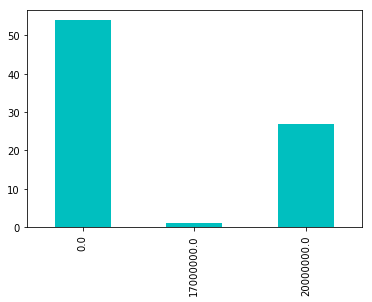

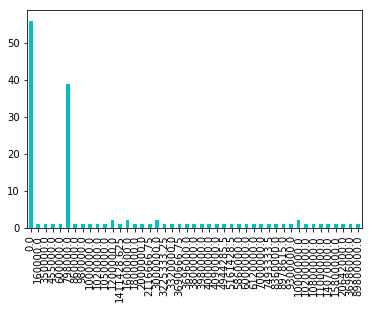

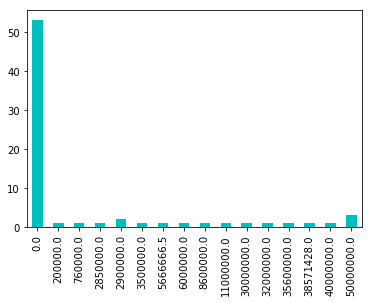

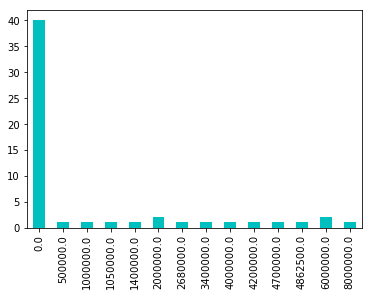

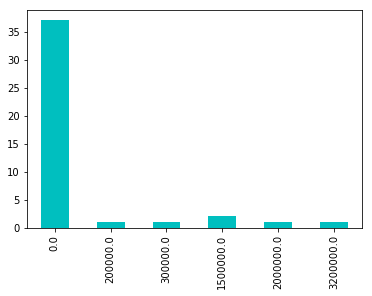

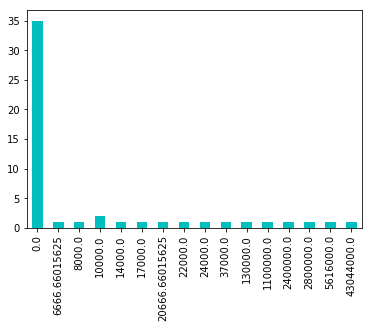

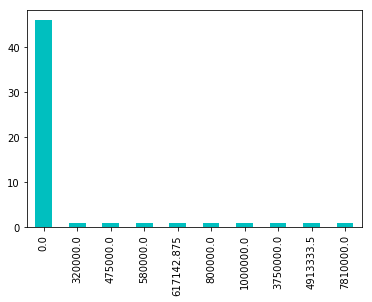

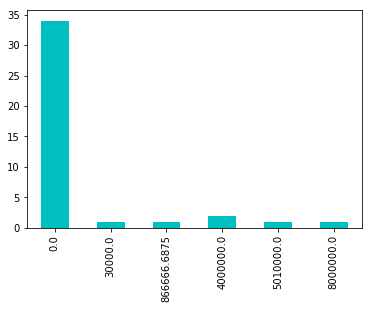

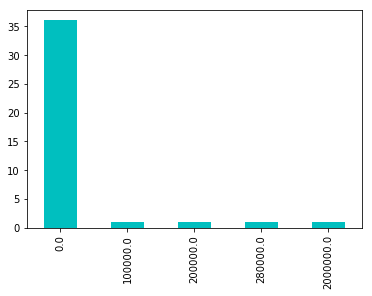

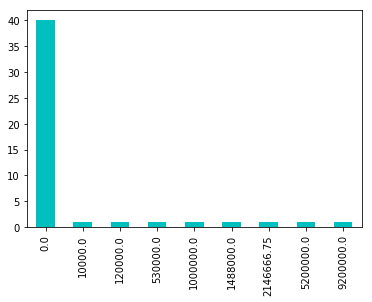

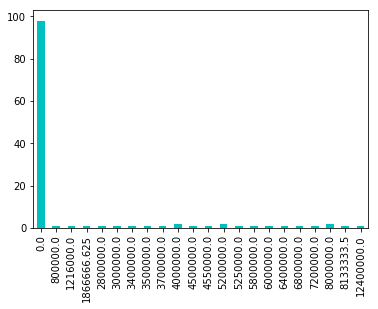

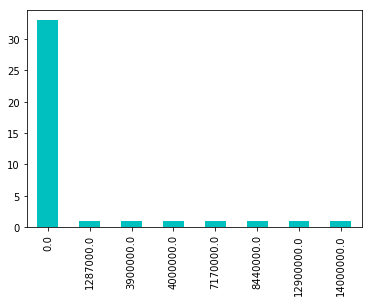

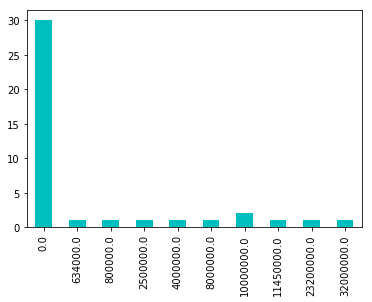

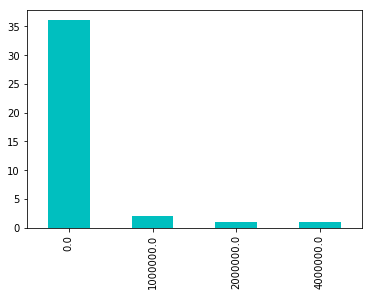

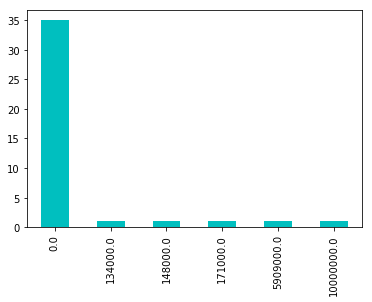

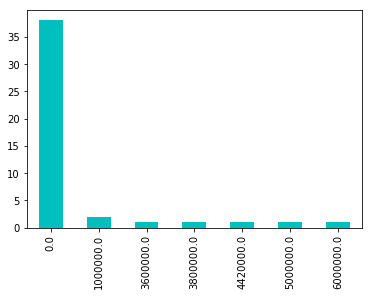

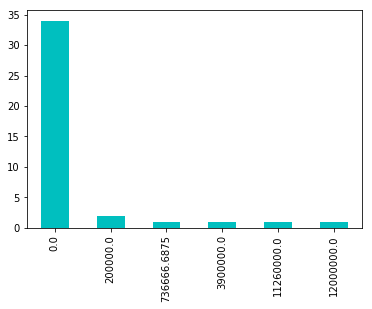

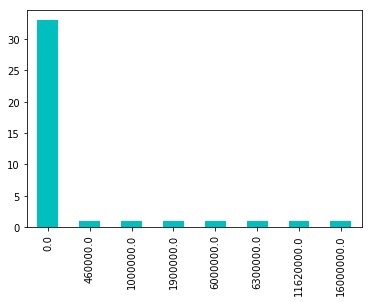

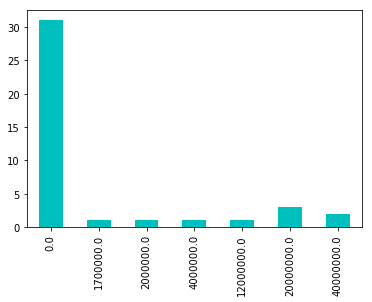

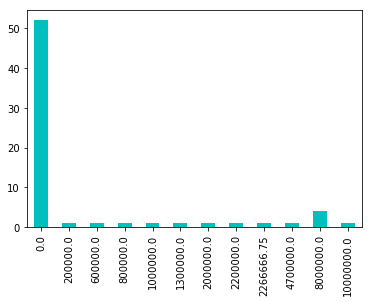

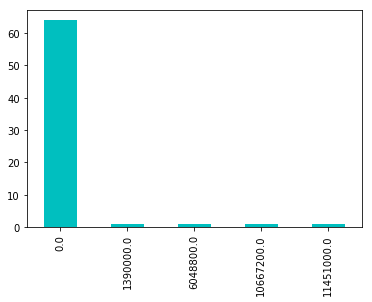

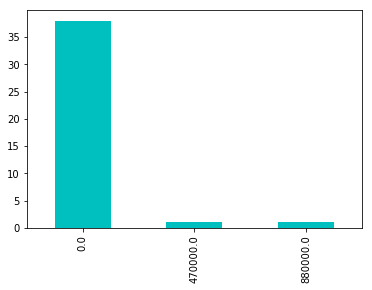

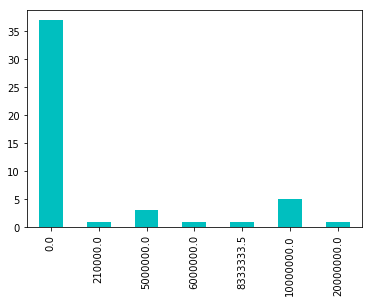

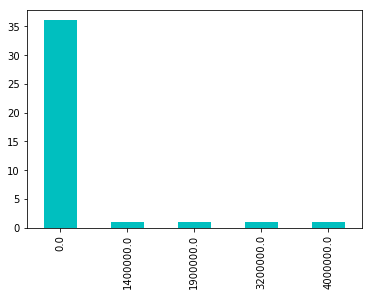

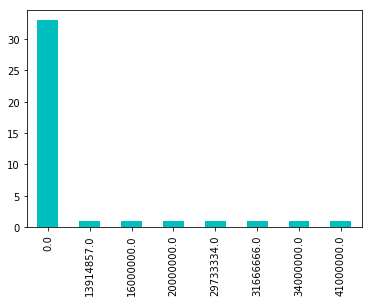

In [86]:
%time
for i in range(25):
    cnt = 51 * i + 23
    values = train_test_allvalues[cnt]
    # values = values[values > 0]
    pd.Series(values).value_counts().sort_index().plot.bar(colors="c")
    # plt.plot(np.arange(len(values)), values)
    # plt.title("values:{}, length:{}".format(cnt, len(values)))
    plt.show()